In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import pandas as pd
import os
%matplotlib inline

In [2]:
nodes_file = "Department_Collaborate_node.csv"
nodes_df = pd.read_csv(nodes_file, header=None, names=["id", "label"])
edges_folder = "Department_Collaborate_Vision/"
layer_networks = {}

In [3]:
for edge_file in os.listdir(edges_folder):
    if edge_file.endswith("_edges.csv"):
        layer_name = edge_file.replace("_edges.csv", "")
        edge_path = os.path.join(edges_folder, edge_file)
        edges_df = pd.read_csv(edge_path)

        G = nx.Graph()

        for _, row in nodes_df.iterrows():
            G.add_node(row['id'], label=row['label'])

        for _, row in edges_df.iterrows():
            G.add_edge(row['Start_Node'], row['End_Node'], weight=row['Weight'], layer=layer_name)

        layer_networks[layer_name] = G

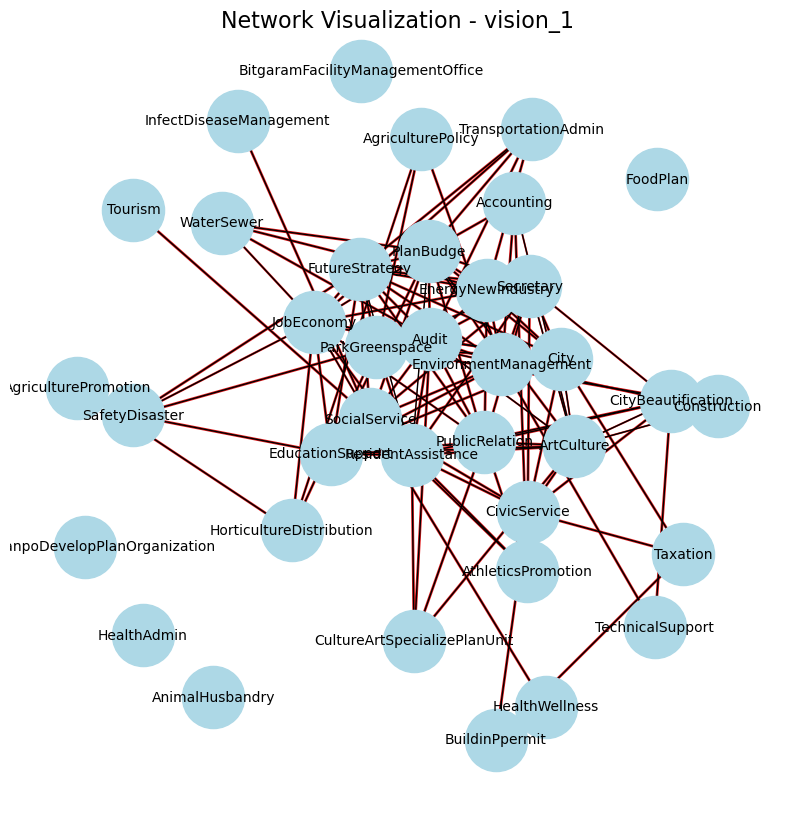

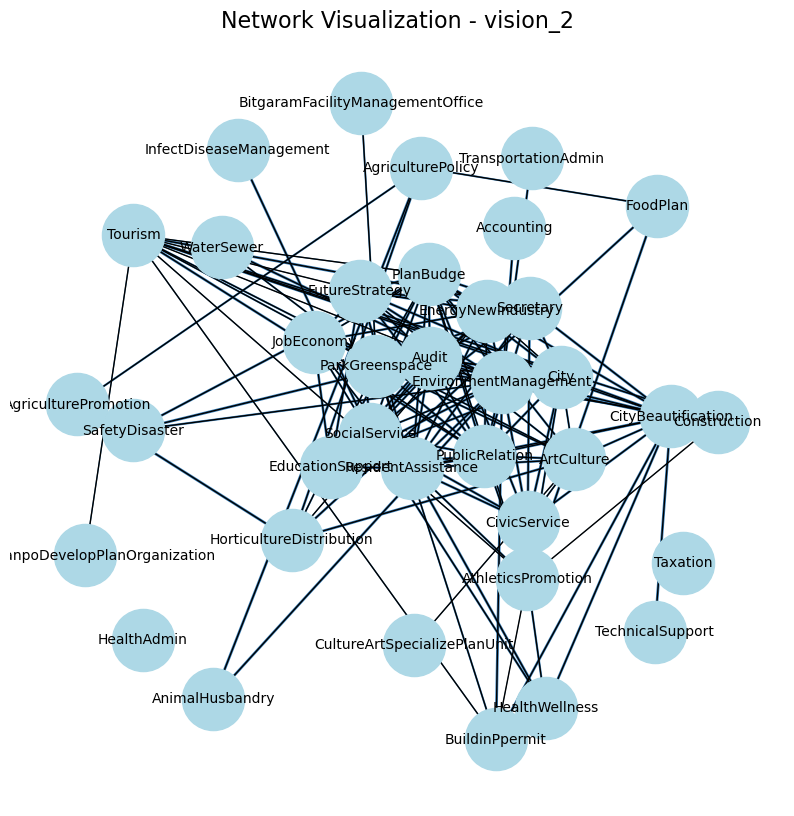

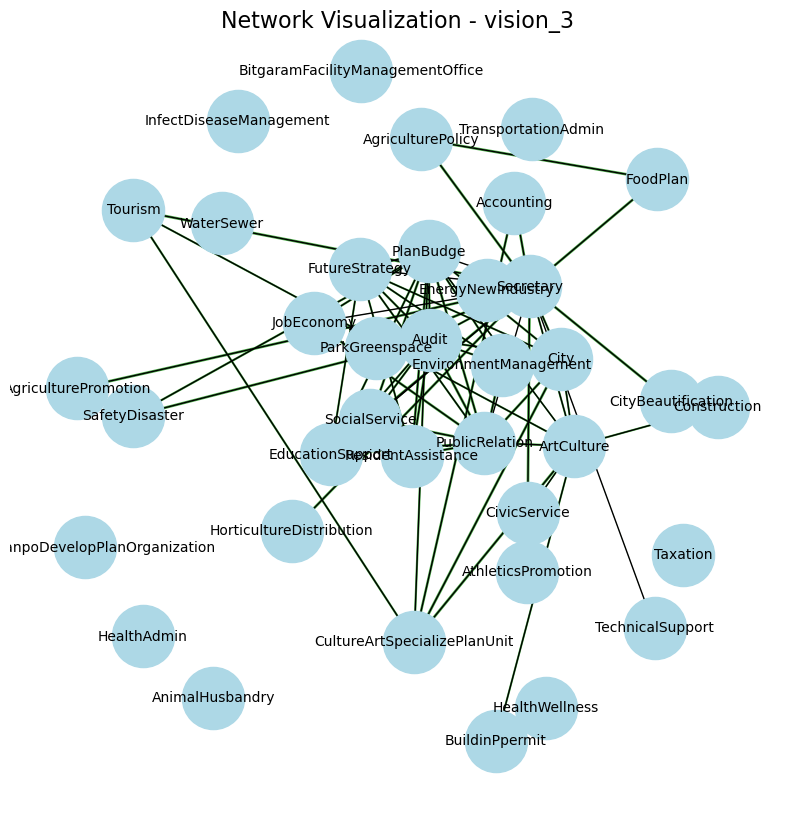

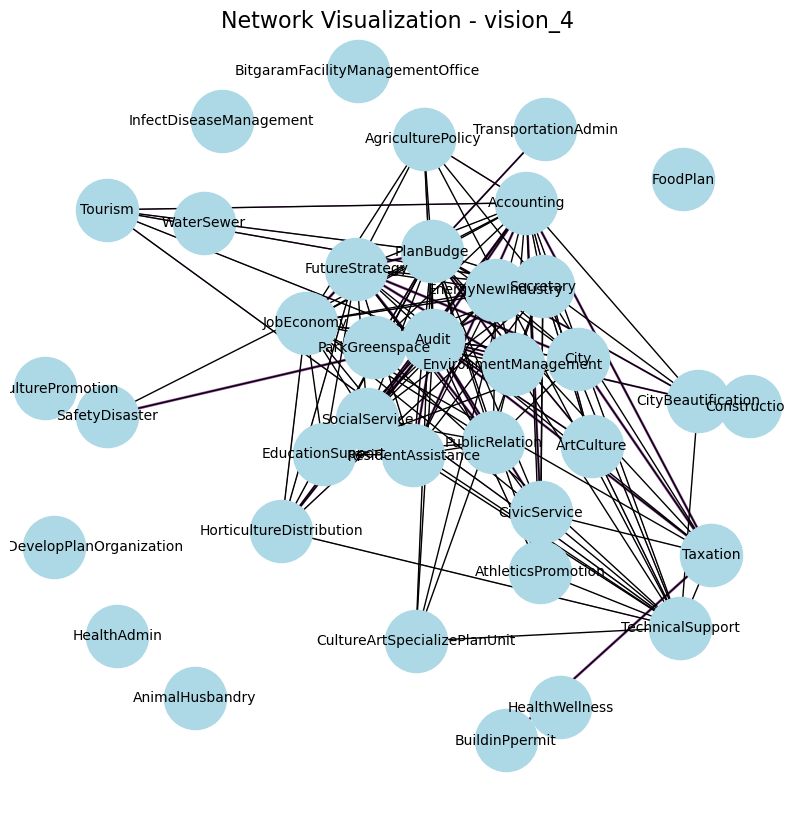

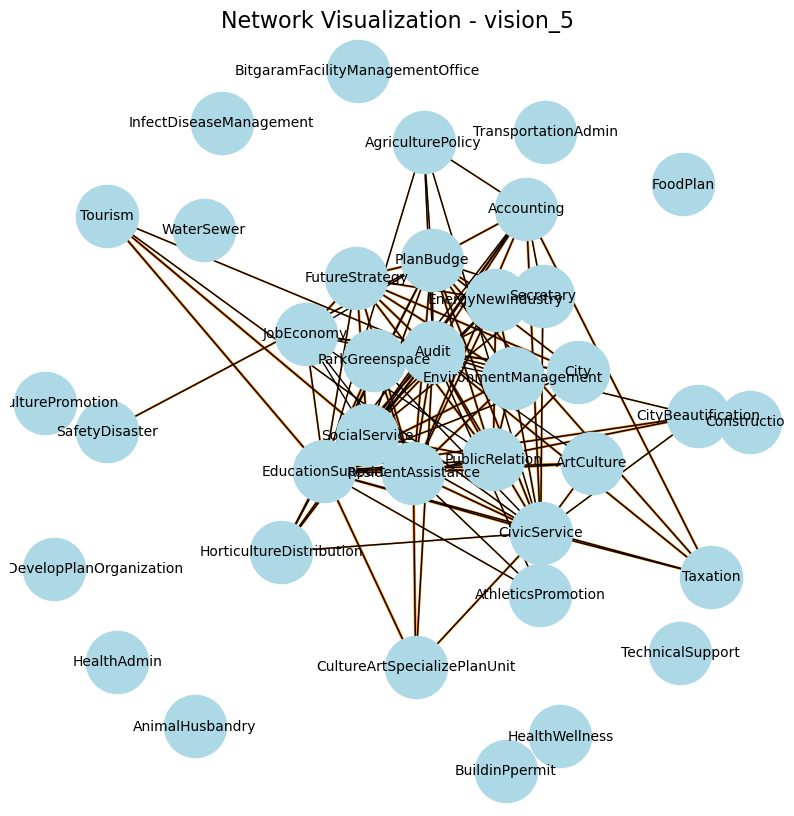

In [11]:
layer_colors = plt.cm.Set1(range(len(layer_networks)))
layer_to_color = {layer_name: color for layer_name, color in zip(layer_networks.keys(), layer_colors)}

pos = nx.spring_layout(list(layer_networks.values())[0], k=80.0, iterations=200)

for layer_name, G in layer_networks.items():
    plt.figure(figsize=(10, 10))

    edges = list(G.edges(data=True))
    weights = [d['weight'] for _, _, d in edges]

    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v) for u, v, _ in edges],
        edge_color=[layer_to_color[layer_name]] * len(edges),
        width=[w / max(weights) * 2 for w in weights], 
    )

    nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), 
            node_size=2000, node_color="lightblue", font_size=10, font_color="black")
    
    plt.title(f"Network Visualization - {layer_name}", fontsize=16)
    plt.savefig(f"test_images/{layer_name}_network.png", transparent=True)
    plt.show()

G = nx.MultiGraph()

In [45]:
node_file = "Department_Collaborate_node.csv"
edges_folder = "Department_Collaborate_Vision/"

nodes_df = pd.read_csv(node_file, header=None, names=["id", "label"])

G = nx.MultiGraph()

for _, row in nodes_df.iterrows():
    G.add_node(row['id'], label=row['label'])

for edge_file in os.listdir(edges_folder):
    if edge_file.endswith("_edges.csv"):
        layer_name = edge_file.replace("_edges.csv", "")
        edge_path = os.path.join(edges_folder, edge_file)
        edges_df = pd.read_csv(edge_path)
        
        for _, row in edges_df.iterrows():
            G.add_edge(row['Start_Node'], row['End_Node'], weight=row['Weight'], layer=layer_name)

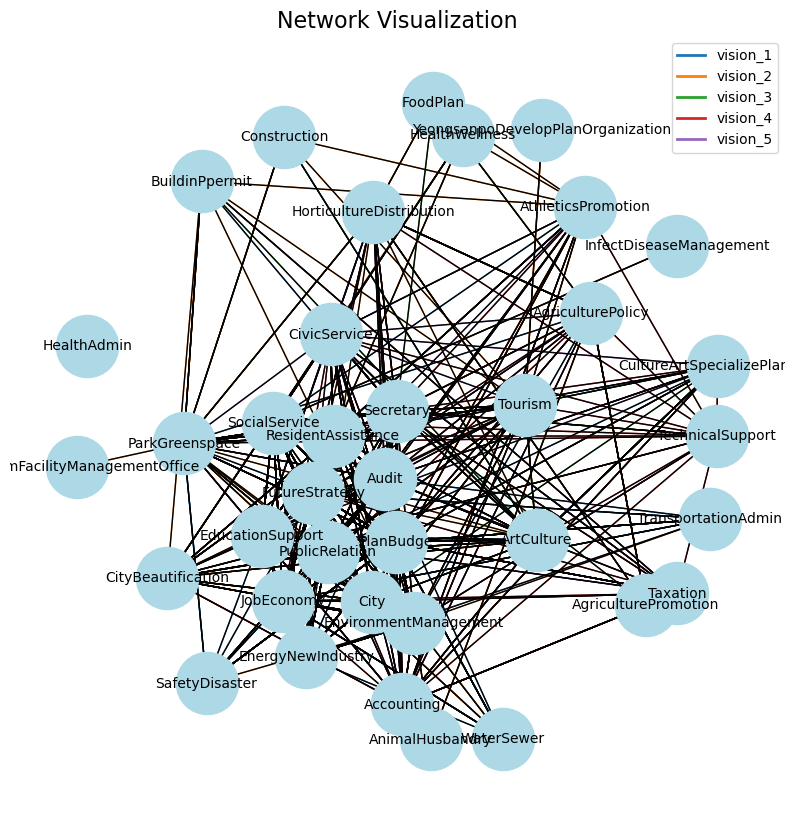

In [55]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=100.0, iterations=100)
# pos = nx.circular_layout(G)

layers = sorted({data['layer'] for _, _, data in G.edges(data=True)}) 
colors = plt.cm.tab10(range(len(layers)))
layer_to_color = {layer: color for layer, color in zip(layers, colors)}
for layer in layers:
    edges = [(u, v) for u, v, d in G.edges(data=True) if d['layer'] == layer]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=[layer_to_color[layer]] * len(edges), label=layer)

nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), 
        node_size=2000, node_color="lightblue", font_size=10, font_color="black")

plt.title("Network Visualization", fontsize=16)
plt.legend(handles=[plt.Line2D([0], [0], color=color, lw=2, label=layer) for layer, color in layer_to_color.items()])
plt.show()